<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Keys" data-toc-modified-id="Keys-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Keys</a></span></li><li><span><a href="#Filtering-VCF-File" data-toc-modified-id="Filtering-VCF-File-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filtering VCF File</a></span></li><li><span><a href="#LDAK-package" data-toc-modified-id="LDAK-package-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>LDAK package</a></span><ul class="toc-item"><li><span><a href="#Genetic-Relatedness-Matrix" data-toc-modified-id="Genetic-Relatedness-Matrix-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Genetic Relatedness Matrix</a></span></li></ul></li><li><span><a href="#Pooling-Log2Fold-Change-data-for-Natural-Isolates" data-toc-modified-id="Pooling-Log2Fold-Change-data-for-Natural-Isolates-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pooling Log<sub>2</sub>Fold Change data for Natural Isolates</a></span></li><li><span><a href="#Regression-Analysis---Euclidean-distance-vs-Genetic-distance" data-toc-modified-id="Regression-Analysis---Euclidean-distance-vs-Genetic-distance-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Regression Analysis - Euclidean distance vs Genetic distance</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Heatmap-based-on-Genetic-relatedness" data-toc-modified-id="Heatmap-based-on-Genetic-relatedness-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Heatmap based on Genetic relatedness</a></span></li><li><span><a href="#Heatmap-based-on-Euclidean-distance" data-toc-modified-id="Heatmap-based-on-Euclidean-distance-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Heatmap based on Euclidean distance</a></span></li><li><span><a href="#Genetic-relatedness-vs-Euclidean-distance" data-toc-modified-id="Genetic-relatedness-vs-Euclidean-distance-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Genetic relatedness vs Euclidean distance</a></span></li></ul></li><li><span><a href="#Mantel's-Test---Genetic-relatedness-vs-Euclidean-distance" data-toc-modified-id="Mantel's-Test---Genetic-relatedness-vs-Euclidean-distance-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Mantel's Test - Genetic relatedness vs Euclidean distance</a></span><ul class="toc-item"><li><span><a href="#Dendrogram-of-Natural-Isolates" data-toc-modified-id="Dendrogram-of-Natural-Isolates-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Dendrogram of Natural Isolates</a></span></li></ul></li><li><span><a href="#Defunct" data-toc-modified-id="Defunct-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Defunct</a></span></li></ul></div>

# Keys

In [1]:
import json
import math
import scipy
import conorm
import mantel
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from scipy import stats
import scipy.stats
from scipy.stats import mannwhitneyu
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv
import gffpandas.gffpandas as gffpd
import sklearn
from sklearn.metrics import r2_score
import os, re
import statistics
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from itertools import combinations
%load_ext rpy2.ipython

## Total strains = 24 
## NA1 = GB119, GB141 (cloneA), GB66, GB123, GB13, GB117, GB49, GB57 (cloneA), CC-3063, CC-3061, CC-3059, CC-3060, W13-2, W13-1
## NA2 = CC-2344, CC-2931, CC-3079, CC-2343, CC-1952, CC-2342, CC-2932, JG4-1, BMS-1, CL3-1

NA1 = ['CC3063', 'CC3061', 'CC3059', 'CC3060', 'GB119', 'GB141', 'GB66', 'GB123', 'GB13', 'GB117', 'W13-1']
# NA1 = ['CC3063', 'CC3061', 'CC3059', 'CC3060', 'GB119', 'GB141', 'GB66', 'GB123', 'GB13', 'GB117', 'W13-1', 'W13-2']
NA2 = ['CC2344', 'CC2931', 'CC3079', 'CC2343', 'CC1952', 'CC2342', 'CC2932', 'CL3-1', 'BMS-1', 'JG4-1']
NOsnpdiffs = ['GB49', 'GB57']

# Filtering VCF File

In [2]:
# import vcf
# from vcf import Reader
# import re

# vcf_file = '/research/projects/chlamydomonas/NIexpression/data/snp_differences/species_wide.v6.vcf.gz'

# vcf_reader = vcf.Reader(filename = vcf_file)
# vcf_writer = vcf.Writer(open('/research/projects/chlamydomonas/NIexpression/data/snp_differences/filtered_species_wide3.v6.vcf.gz', 'w'), vcf_reader)
# for record in vcf_reader:
#     res = re.search('RGQ', record.FORMAT) 
#     if not res:
#         if len(record.REF) == 1 and len(record.ALT) == 1: ## finding biallelic sites
#             if len(record.REF[0]) == 1 and len(record.ALT[0]) == 1:
#                 if record.ALT[0] != '*' and record.REF[0] != '*': ## removing sites with deletions
#                     count = 0
#                     for sample in record.samples:
#                         try:
#                             if sample['GQ'] >= 30:  ## picking sites with GQ > 30 in 80% of total individuals (58/73)
#                                 count += 1
#                         except:
#                             continue
#                     if count > 58:
#                         vcf_writer.write_record(record)

In [8]:
import vcf
from vcf import Reader
import re

vcf_file = '/research/projects/chlamydomonas/NIexpression/data/snp_differences/filtered_species_wide_21indiv.vcf.gz'

vcf_reader = vcf.Reader(filename = vcf_file)
vcf_writer = vcf.Writer(open('/research/projects/chlamydomonas/NIexpression/data/snp_differences/filtered_species_wide2_21indiv.vcf.gz', 'w'), vcf_reader)
for record in vcf_reader:
    if record.CHROM in [str(i+1) for i in range(17)]:
        count = 0
        for sample in record.samples:
            try:
                if sample['GQ'] >= 30: 
                    count += 1
            except:
                continue
        if count == 20:  ## making sure there are no missing sites
            vcf_writer.write_record(record)

# LDAK package

## Genetic Relatedness Matrix

In [2]:
grm_file = '/research/projects/chlamydomonas/NIexpression/data/snp_differences/kinship_grm.grm.gz'
dist = pd.read_csv(grm_file, delimiter = ',', header = None)
dist = dist[0].str.split(' ', expand = True)
dist.columns = ['ID1', 'ID2', 'shared_SNPs', 'grm']

sample_id = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/snp_differences/kinship_grm.grm.id', delimiter = ' ', header = None)
dic = {i+1:sample_id.loc[i, 1] for i in range(len(sample_id))}
dist['ID1'] = dist['ID1'].astype(int)
dist['ID2'] = dist['ID2'].astype(int)
dist['shared_SNPs'] = dist['shared_SNPs'].astype(int)
dist['grm'] = dist['grm'].astype(float)
dist['ID1'] = dist['ID1'].replace(dic)
dist['ID2'] = dist['ID2'].replace(dic)
dist

,ID1,ID2,shared_SNPs,grm
0,BMS-1,BMS-1,1015028,1.061132
1,CC1952,BMS-1,1015028,0.065449
2,CC1952,CC1952,1015028,1.215451
3,CC2342,BMS-1,1015028,0.079770
4,CC2342,CC1952,1015028,0.048334
...,...,...,...,...
226,W13-1,GB13,1015028,-0.021176
227,W13-1,GB141,1015028,-0.039109
228,W13-1,GB66,1015028,-0.033368
229,W13-1,JG4-1,1015028,-0.085146


# Pooling Log<sub>2</sub>Fold Change data for Natural Isolates

In [27]:
dir_path = '/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/'
res = []
label = []
for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)
        label.append(path.replace('_vs_pseudoreference', ''))
        
L2F = pd.DataFrame()
for i in range(len(res)):
    L2F[label[i]] = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/genes_log2fold/' + res[i], delimiter = '\t')['log2FoldChange']

L2F = L2F.dropna()

#### Exporting log2 fold values ####
L2F.to_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/NI+MA_log2Fold', sep = '\t', index = True, header = True)

# Regression Analysis - Euclidean distance vs Genetic distance

In [3]:
L2F = pd.read_csv('/research/projects/chlamydomonas/NIexpression/data/raw_counts/NI+MA_log2Fold', delimiter = '\t', index_col = 'Unnamed: 0')
columns = pd.Series(L2F.columns).replace({'CL3':'CL3-1', 'BMS1':'BMS-1', 'W13_1':'W13-1', 'W13_2':'W13-2', 'JG4':'JG4-1'})
L2F.columns = columns

#### Isolating the genotypes of interest ####
NI_strains = dist.loc[dist['ID1'].isin(NA1 + NA2) & dist['ID2'].isin(NA1 + NA2)]
remove = NI_strains['ID1'][NI_strains['ID1'] == NI_strains['ID2']].index
NI_strains = NI_strains.drop(remove)

#### Calculating the euclidean distance of log2 fold values from every strain pair ####
comb = combinations(NA1 + NA2, 2)
for i in list(comb):
    try:
        index = NI_strains.loc[NI_strains['ID1'].isin(i) & NI_strains['ID2'].isin(i)].index.values[0]
        NI_strains.at[index, 'euclidean_distance'] = math.dist(L2F[i[0]], L2F[i[1]])
    except:
        continue
NI_strains = NI_strains.dropna()
#### Regression Analysis of the euclidean distance vs genetic distance ####
results = ols('euclidean_distance ~ grm', data = NI_strains).fit()
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     euclidean_distance   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     43.31
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           3.73e-10
Time:                        14:52:00   Log-Likelihood:                -920.08
No. Observations:                 210   AIC:                             1844.
Df Residuals:                     208   BIC:                             1851.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    218.5069      1.455    150.203      0.000     215.639     221.375
grm          -74.1404     11.266     -6.581      0.000     -96.351     -51.930
==============================================================================
Omnibus:                        0.018   Durbin-Watson:                   1.199
Prob(Omnibus):                  0.991   Jarque-Bera (JB):                0.017
Skew:                          -0.011   Prob(JB):                        0.992
Kurtosis:                       2.962   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Plots

In [4]:
NI_strains['substructure'] = 'NA1 x NA2' ## adding subpopulation to each strain
NI_strains.loc[NI_strains.loc[(NI_strains['ID1'].isin(NA1)) & (NI_strains['ID2'].isin(NA1))].index, 'substructure'] = 'NA1'
NI_strains.loc[NI_strains.loc[(NI_strains['ID1'].isin(NA2)) & (NI_strains['ID2'].isin(NA2))].index, 'substructure'] = 'NA2'

dup = pd.DataFrame(index = NI_strains.index)
for i in NI_strains.index:
    dup.loc[i, 'ID1'] = NI_strains.loc[i, 'ID2']
    dup.loc[i, 'ID2'] = NI_strains.loc[i, 'ID1']
    dup.loc[i, 'euclidean_distance'] = NI_strains.loc[i, 'euclidean_distance']
    dup.loc[i, 'substructure'] = NI_strains.loc[i, 'substructure']
    dup.loc[i, 'grm'] = NI_strains.loc[i,'grm']

NI_strains2 = pd.concat([NI_strains, dup], axis = 0)

display(dup.loc[dup['substructure'] == 'NA2']['euclidean_distance'].median())
display(dup.loc[dup['substructure'] == 'NA1']['euclidean_distance'].median())

display(dup.loc[dup['substructure'] == 'NA2']['grm'].median())
display(dup.loc[dup['substructure'] == 'NA1']['grm'].median())

219.9801856875087

214.0920581247778

0.056073

0.050338

## Heatmap based on Genetic relatedness

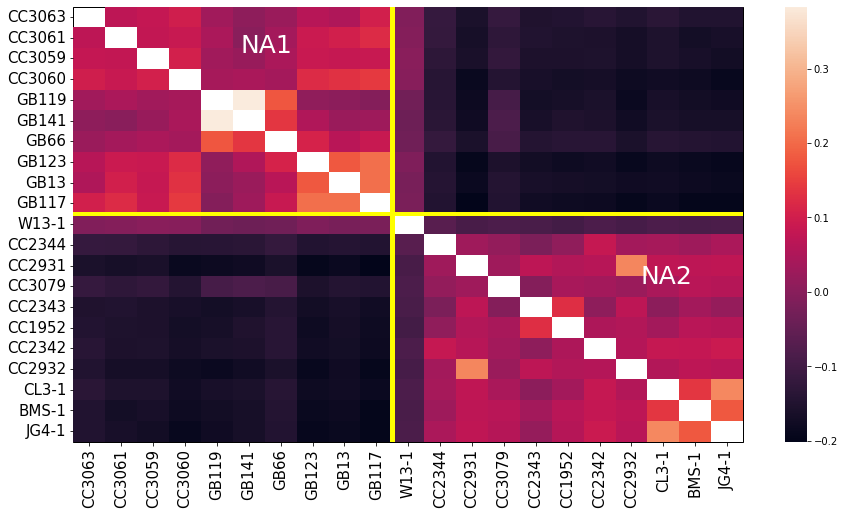

In [7]:
a = NI_strains2.pivot(index = 'ID1', columns = 'ID2', values = 'grm')
a = a.loc[:, NA1 + NA2]
a = a.loc[NA1 + NA2, :]
plt.figure(figsize = (15, 8), edgecolor = 'black')
ax = sns.heatmap(a)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
plt.figtext(0.65, 0.40, f'NA2', size = 25, color = 'white')
plt.figtext(0.28, 0.80, f'NA1', size = 25, color = 'white')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.axvline(10, color = 'yellow', linewidth=5)
plt.axhline(10, color = 'yellow', linewidth=4)
plt.savefig('/research/projects/chlamydomonas/NIexpression/data/plots/GDsimilarity_heatmap.pdf', format = 'pdf', dpi = 1200)

## Heatmap based on Euclidean distance

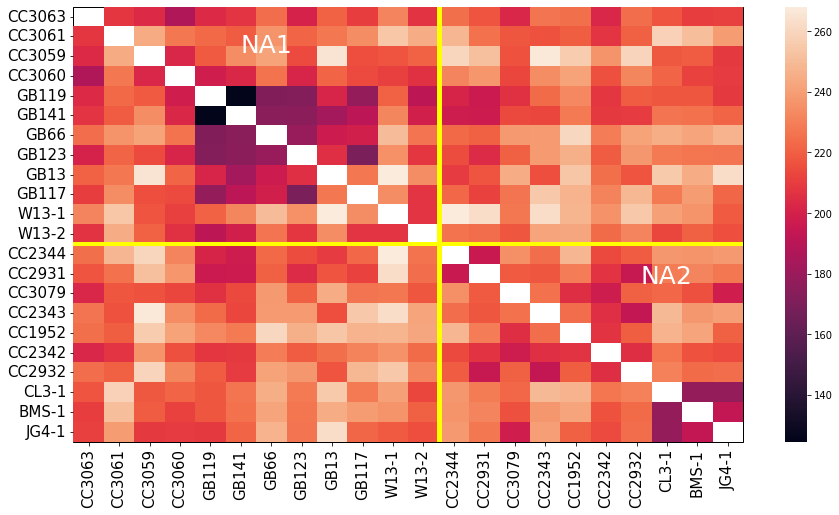

In [11]:
a = NI_strains2.dropna().pivot(index = 'ID1', columns = 'ID2', values = 'euclidean_distance')
a = a.loc[:, NA1 + NA2]
a = a.loc[NA1 + NA2, :]
plt.figure(figsize = (15, 8), edgecolor = 'black')
ax = sns.heatmap(a)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth(1)  
plt.figtext(0.65, 0.40, f'NA2', size = 25, color = 'white')
plt.figtext(0.28, 0.80, f'NA1', size = 25, color = 'white')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel(None)
plt.ylabel(None)
plt.axvline(12, color = 'yellow', linewidth=5)
plt.axhline(12, color = 'yellow', linewidth=4)
plt.savefig('/research/projects/chlamydomonas/NIexpression/data/plots/EDdissimilarity_heatmap.pdf', format = 'pdf', dpi = 1200)

## Genetic relatedness vs Euclidean distance

<ipython-input-54-5769a211a3a8>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(NI_strains['grm'], p(NI_strains['grm']), "r--", linewidth= 3, color = 'red')


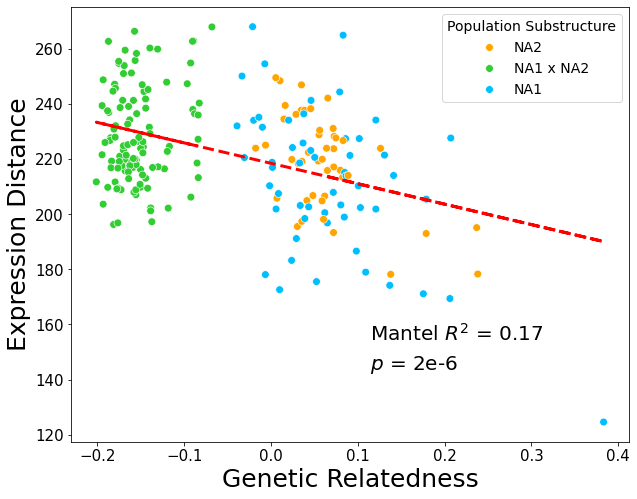

In [54]:
z = np.polyfit(NI_strains['grm'], NI_strains['euclidean_distance'], 1)
p = np.poly1d(z)
stats.pearsonr(NI_strains['grm'], NI_strains['euclidean_distance'])
plt.figure(figsize = (10,8))
a = sns.scatterplot(data = NI_strains, x = 'grm', y = 'euclidean_distance', hue = 'substructure', s = 60, palette = ['orange', 'limegreen', 'deepskyblue'])
plt.legend(loc='upper right', title='Population Substructure', fontsize = 14)
plt.setp(a.get_legend().get_title(), fontsize=14)
plt.figtext(0.54, 0.30, f'Mantel $R^2$ = 0.17', size = 20)
plt.figtext(0.54, 0.25, f'$p$ = 2e-6', size = 20)
plt.xlabel('Genetic Relatedness', size = 25)
plt.ylabel('Expression Distance', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot(NI_strains['grm'], p(NI_strains['grm']), "r--", linewidth= 3, color = 'red')
plt.savefig('/research/projects/chlamydomonas/NIexpression/data/plots/EDvsGD(intraspecies).pdf', format = 'pdf', dpi = 1600)

# Mantel's Test - Genetic relatedness vs Euclidean distance

In [8]:
#### Creating genetic matrix (6 x 6) ####
for subpop in [NA1, NA2, NA1+NA2]:
    gd_matrix = []
    counter = []
    for i in subpop:
        array = []
        for a in subpop:
            if a == i:
                array.append(0)
            else:
                try:
                    array.append(NI_strains.loc[(NI_strains['ID1'].isin([i] + [a])) & (NI_strains['ID2'].isin([i] + [a]))]['grm'].values[0])
                    counter.append((a, i))
                except:
                    continue
        if len(array) == 1:
            print(a + i)
        gd_matrix.append(array)
    
    #### Creating expression matrix (6 x 6) ####
    ed_matrix = []
    counter2 = []
    for i in subpop:
        array = []
        for a in subpop:
            if a == i:
                array.append(0)
            else:
                try:
                    array.append(NI_strains.loc[(NI_strains['ID1'].isin([i] + [a])) & (NI_strains['ID2'].isin([i] + [a]))]['euclidean_distance'].values[0])
                    counter2.append((a, i))
                except:
                    continue
        ed_matrix.append(array)
        
    #######################
    #### Mantel's Test ####
    #######################
    
    # Results = veridical correlation, empirical p-value, z-score #
    a = mantel.test(gd_matrix, ed_matrix, method='pearson', perms=1000000, tail='lower')
    
    display(a[0]**2, a[1])

0.26208043289381083

0.000271

0.3248068176579278

0.000124

0.1723280532476403

1e-06

## Dendrogram of Natural Isolates

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205]),
 [Text(5, 0, 'GB141'),
  Text(15, 0, 'GB66'),
  Text(25, 0, 'GB119'),
  Text(35, 0, 'CC3061'),
  Text(45, 0, 'CC3060'),
  Text(55, 0, 'GB123'),
  Text(65, 0, 'GB13'),
  Text(75, 0, 'GB117'),
  Text(85, 0, 'CC3059'),
  Text(95, 0, 'W13-1'),
  Text(105, 0, 'CC1952'),
  Text(115, 0, 'JG4-1'),
  Text(125, 0, 'CL3-1'),
  Text(135, 0, 'BMS-1'),
  Text(145, 0, 'CC2343'),
  Text(155, 0, 'CC2344'),
  Text(165, 0, 'CC2931'),
  Text(175, 0, 'CC3079'),
  Text(185, 0, 'CC3063'),
  Text(195, 0, 'CC2342'),
  Text(205, 0, 'CC2932')])

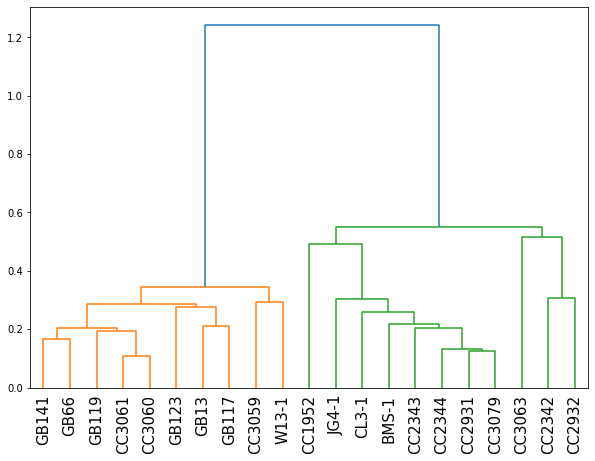

In [9]:
import scipy.cluster.hierarchy as sch
import scipy.spatial as scs

Z = sch.linkage(gd_matrix, method='complete')
plt.figure(figsize = (10,7))
P = sch.dendrogram(Z, labels = NA2 + NA1, leaf_rotation = 90)
plt.xticks(fontsize = 15, rotation = 90)